In [139]:
%pip install scikit-learn
%pip install nltk
%pip install contractions
%pip install textblob
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


Note: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


DEPRECATION: Loading egg at c:\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
import re
import contractions


In [141]:
df = pd.read_json('dataset\Sarcasm_Headlines_Dataset_v2.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 670.9+ KB


## Visualisasi

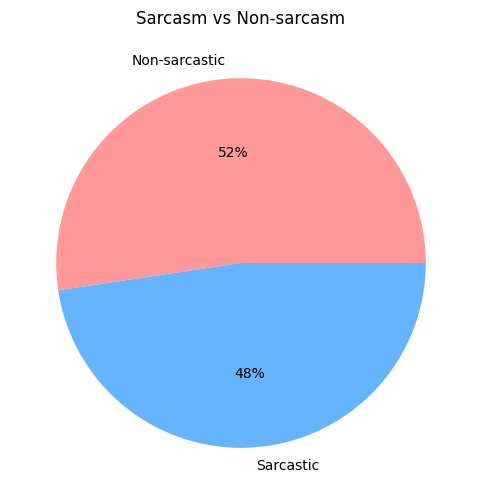

In [143]:
plt.figure(figsize=(8, 6))
# pie plot
plt.pie(df['is_sarcastic'].value_counts(), labels=['Non-sarcastic', 'Sarcastic'], autopct='%1.0f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Sarcasm vs Non-sarcasm')
plt.show()

Looks great! classification is pretty balanced, so we don't need to worry about that. Let's take a look at the data.

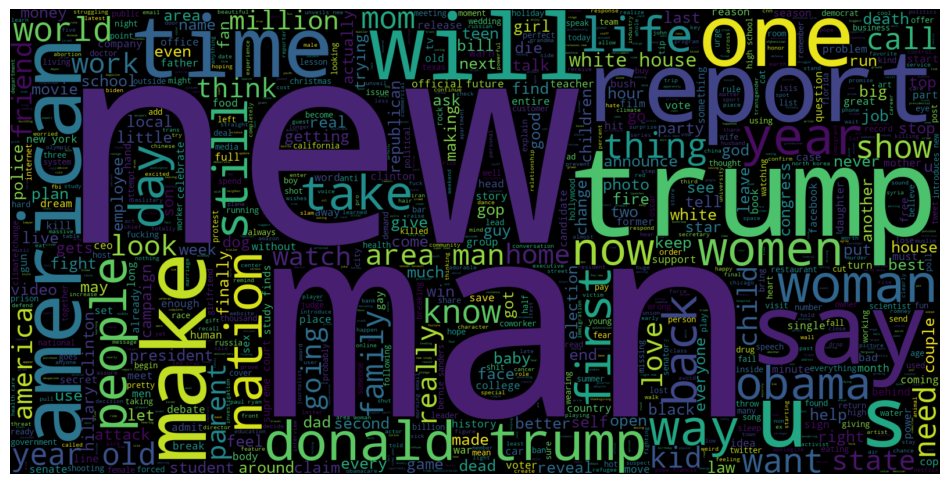

In [144]:
# wordcloud
from wordcloud import WordCloud
plt.figure(figsize=(12, 8))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df['headline']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Engineering

In [145]:
## Subjectivity score
from textblob import TextBlob
df['subjectivity'] = df['headline'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.head()

,is_sarcastic,headline,article_link,subjectivity
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,0.000
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,0.525
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,0.600
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,0.000
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,1.000


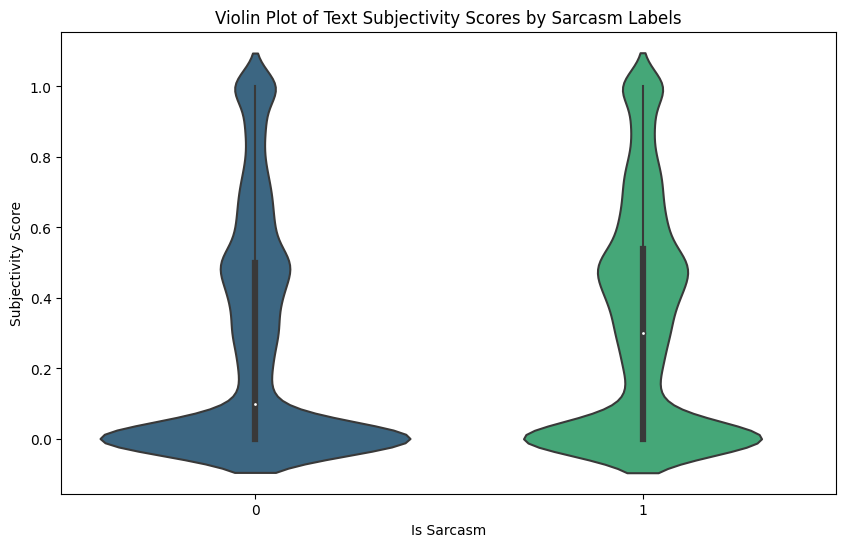

In [146]:
# Create a violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='is_sarcastic', y='subjectivity', data=df, palette='viridis')

# Set labels and title
plt.title('Violin Plot of Text Subjectivity Scores by Sarcasm Labels')
plt.xlabel('Is Sarcasm')
plt.ylabel('Subjectivity Score')

# Show the plot
plt.show()


## Preprocessing

In [147]:
df.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
subjectivity    0
dtype: int64

In [148]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

def penn2morphy(penntag):
   """ Converts Penn Treebank tags to WordNet. """
   morphy_tag = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
   try:
       return morphy_tag[penntag[:2]]
   except:
       return 'n' 

def preprocess_text(text):
   # Convert to lowercase
   text = text.lower()

   # Expand contractions
   text = contractions.fix(text)

   # Remove special characters and symbols
   text = re.sub(r"[^a-zA-Z0-9]", " ", text)

   # Tokenization
   tokens = word_tokenize(text)

   # Remove stop words
   stop_words = set(stopwords.words('english'))
   tokens = [token for token in tokens if token not in stop_words]

   # Lemmatization (using WordNet Lemmatizer)
   lemmatizer = WordNetLemmatizer()
   tokens = [lemmatizer.lemmatize(token, pos=penn2morphy(tag)) for token, tag in pos_tag(tokens)]

   # Rejoin tokens into a single string
   preprocessed_text = ' '.join(tokens)

   return preprocessed_text

# Apply preprocessing to the 'headline' column
df['processed_headline'] = df['headline'].apply(lambda x: preprocess_text(x))

# Display the DataFrame with the processed headline column
df.head()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zhafar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zhafar\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\zhafar\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


,is_sarcastic,headline,article_link,subjectivity,processed_headline
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,0.000,thirtysomething scientist unveil doomsday cloc...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,0.525,dem rep totally nails congress fall short gend...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,0.600,eat veggie 9 deliciously different recipe
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,0.000,inclement weather prevents liar get work
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,1.000,mother come pretty close use word stream corre...


In [149]:
# get all distinct words count for processed_headline
from collections import Counter
all_words = [word for tokens in df['processed_headline'] for word in tokens]
sentence_lengths = [len(tokens) for tokens in df['processed_headline']]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))

1361396 words total, with a vocabulary size of 37


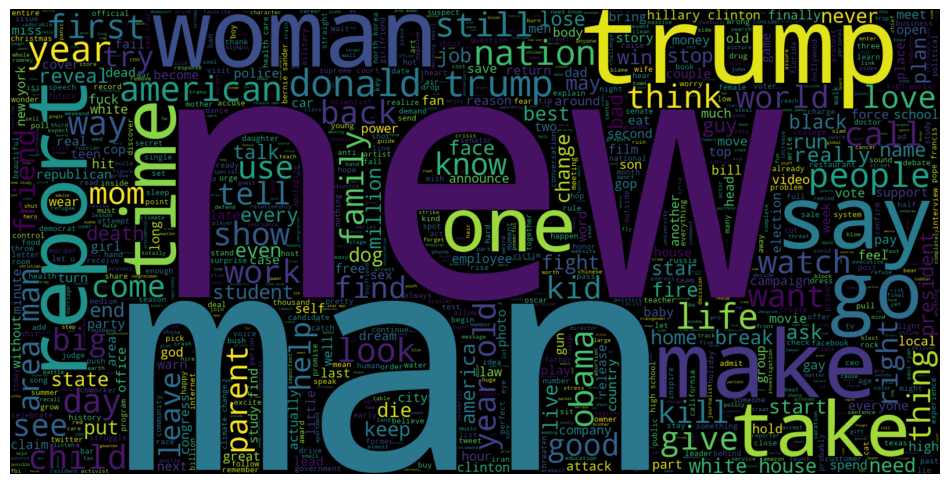

In [150]:
# wordcloud on processed text
plt.figure(figsize=(12, 8))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(df['processed_headline']))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

## Feature Extraction

In [151]:
# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=65532, ngram_range=(1, 4))
X = vectorizer.fit_transform(df['processed_headline'])
y = df['is_sarcastic']
print(X[:10])


  (0, 11090)	0.3951988843625273
  (0, 7220)	0.3951988843625273
  (0, 58990)	0.38401233991014594
  (0, 14762)	0.2925788918182507
  (0, 11088)	0.27681234294335744
  (0, 4839)	0.31772304996096506
  (0, 7219)	0.3682457910352528
  (0, 63581)	0.2787095530672584
  (0, 58973)	0.252410006116928
  (1, 51569)	0.28522940114110906
  (1, 51568)	0.28522940114110906
  (1, 45868)	0.28522940114110906
  (1, 8596)	0.24463722499500198
  (1, 5298)	0.27428667231298937
  (1, 62524)	0.27428667231298937
  (1, 51567)	0.28522940114110906
  (1, 8053)	0.21600631704511836
  (1, 45855)	0.219315119547543
  (1, 9998)	0.20957205888819416
  (1, 59634)	0.19945979835351868
  (1, 8587)	0.1747308616186137
  (1, 5291)	0.17037854233769845
  (1, 24776)	0.27428667231298937
  (1, 62522)	0.19529956593329767
  (1, 51502)	0.21214429859834905
  :	:
  (7, 64240)	0.292573589927839
  (7, 10399)	0.2625183679386524
  (7, 58123)	0.28957160181309627
  (8, 22831)	0.2928385199099165
  (8, 19944)	0.2928385199099165
  (8, 22830)	0.2928385199099

In [152]:
# Assuming X and y are your features and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1000)


In [153]:
params = {'C': [0.1, 1, 10, 100, 1000],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear', 'saga']
          }
grid_search = GridSearchCV(estimator=LogisticRegression(),
                           param_grid=params,
                           cv=5,
                           verbose=1,
                           n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
model = grid_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [154]:
y_pred = model.predict(X_test)
print(y_pred[:10])

[1 1 1 1 0 0 1 0 0 0]


## Evaluate

In [155]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[2501,  540],
       [ 614, 2069]], dtype=int64)

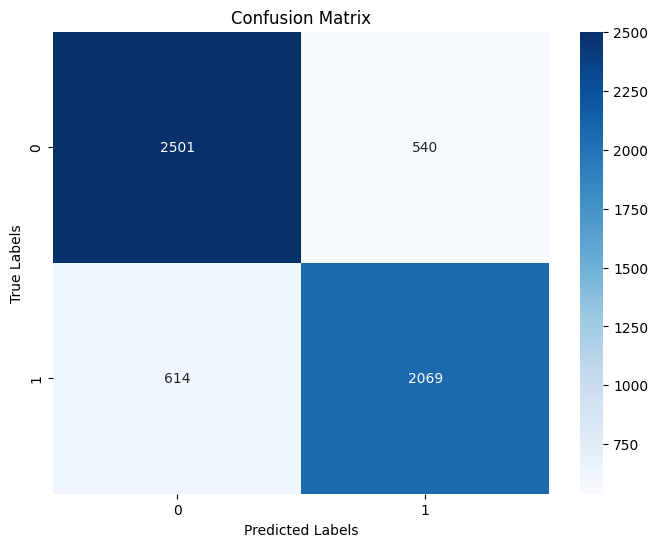

In [156]:
# Visualize Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [157]:
# evaluate
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      3041
           1       0.79      0.77      0.78      2683

    accuracy                           0.80      5724
   macro avg       0.80      0.80      0.80      5724
weighted avg       0.80      0.80      0.80      5724

0.7983927323549965


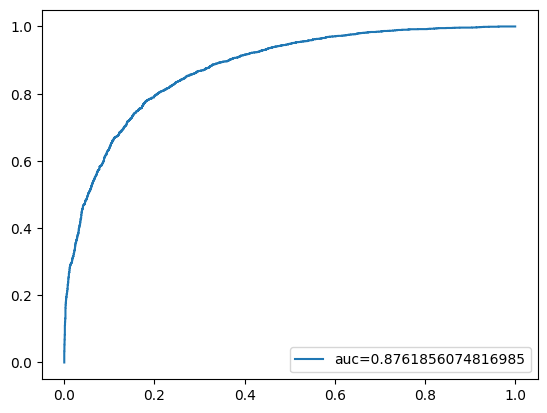

In [158]:
# ROC Curve
y_pred_proba = model.predict_proba(X_test)[::, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label="auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [159]:
# Create predict one function
def predict_one(text):
    # Preprocess the text
    preprocessed_text = preprocess_text(text)

    # Vectorize the preprocessed text
    vectorized_text = vectorizer.transform([preprocessed_text])

    # Make a prediction
    prediction = model.predict(vectorized_text)

    # Return the prediction
    return prediction[0]
# test predict one function


In [160]:
# Test the predict_one function with an example text
example_text = "New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: New Study Reveals That Sleeping Eight Hours a Day Makes You Well-Rested
Prediction: 1


In [161]:
# Test the predict_one function with an example text
example_text = "Health Officials Launch Campaign to Promote Vaccination Awareness"
prediction_result = predict_one(example_text)

# Print the result
print(f'Text: {example_text}')
print(f'Prediction: {prediction_result}')

Text: Health Officials Launch Campaign to Promote Vaccination Awareness
Prediction: 0
